## With Tensorflow

In [18]:
import numpy as np
import tensorflow as tf

In [19]:
def gen_dataset(x, y, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=10000, seed=42)
    dataset = dataset.batch(batch_size=batch_size)
    
    return dataset

def accuracy(y_pred, y):
    return np.mean(abs(y_pred - y)) # Mean Absolute Error | MAE

def test_model(model, x, y):
    dataset = gen_dataset(x, y)
    preds, targets = [], []
    
    for batch_x, batch_y in dataset:
        preds.append(model(batch_x).numpy())
        targets.append(batch_y.numpy())
     
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    return accuracy(preds, targets)

In [20]:
class NeuralNet:
    def __init__(self, input_shape):
        # We take glorot initializer
        initializer = tf.keras.initializers.GlorotUniform()
        
        self.w1 = tf.Variable(initializer(shape=(input_shape, 128)))
        self.b1 = tf.Variable(tf.zeros([128]))
        
        self.w2 = tf.Variable(initializer(shape=(128, 64)))
        self.b2 = tf.Variable(tf.zeros([64]))
        
        self.w3 = tf.Variable(initializer(shape=(64, 1)))
        self.b3 = tf.Variable(tf.zeros([1]))
        
    def __call__(self, inputs):
        return self.forward(inputs)
        
    def forward(self, inputs):
        z1 = tf.matmul(inputs, self.w1) + self.b1
        a1 = tf.keras.activations.relu(z1)
        
        z2 = tf.matmul(a1, self.w2) + self.b2
        a2 = tf.keras.activations.relu(z2)
        
        z3 = tf.matmul(a2, self.w3) + self.b3
        a3 = tf.keras.activations.linear(z3)
        
        return a3
    
    def train(self, X_train, y_train,
             num_epochs = 10,
             batch_size = 32):
        optimizer = tf.keras.optimizers.Adam()
        loss_fn = tf.keras.losses.MSE
        
        losses = []
        
        for e in range(num_epochs):
            train_dataset = gen_dataset(X_train, y_train, batch_size)
            
            for batch_x, batch_y in train_dataset:
                with tf.GradientTape() as tape:
                    output = self.forward(batch_x)
                    loss = tf.reduce_mean(loss_fn(output, batch_y))
                    
                    losses.append(loss.numpy())
                variables = [self.w1, self.b1,
                            self.w2, self.b2,
                            self.w3, self.b3]
                
                grads = tape.gradient(loss, variables)
                optimizer.apply_gradients(zip(grads, variables))
        return losses

In [21]:
from sklearn.datasets import load_boston
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

boston = load_boston() # Iris only have 3 classes

data = np.asarray(boston.data, dtype='float32')
target = np.asarray(boston.target, dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.15,
                                                   random_state=37)
# We put a random state to have reproducible results

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train) # Center and normalize
X_test = scaler.fit_transform(X_test)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((430, 13), (430,)), ((76, 13), (76,)))

In [22]:
model = NeuralNet(X_train.shape[1])
losses = model.train(X_train, y_train,
                    num_epochs=100)

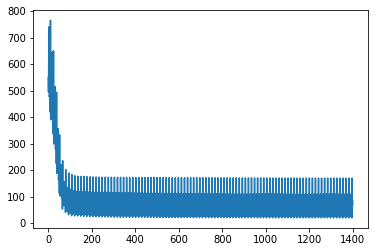

In [23]:
import matplotlib.pyplot as plt

plt.plot(losses)

Error:  70.57317


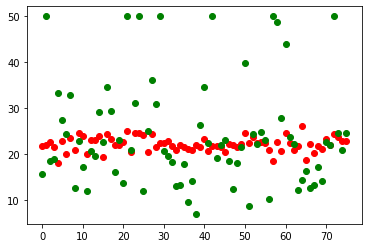

In [24]:
from sklearn.metrics import mean_squared_error

y_train_pred = model(X_train).numpy()
print("Error: ", mean_squared_error(y_train, y_train_pred).mean())

y_pred = model(X_test).numpy() # We take the RELu one
x = np.arange(0, len(X_test))
plt.scatter(x, y_pred, color='red') # Prediction
plt.scatter(x, y_test, color='green')

plt.show()

## With Keras

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
14/14 [==============================] - 0s 691us/step - loss: 558.7441
Epoch 2/100
14/14 [==============================] - 0s 930us/step - loss: 482.8298
Epoch 3/100
14/14 [==============================] - 0s 942us/step - loss: 379.4813
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 243.6204
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 116.0341
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 59.5836
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 40.8698
Epoch 8/100
14/14 [==============================] - 0s 993us/step - loss: 28.6263
Epoch 9/100
14/14 [==============================] - 0s 981us/step - loss: 23.7993
Epoch 10/100
14/14 [==============================] - 0s 977us/step - loss: 21.1701
Epoch 11/100
14/14 [==============================] - 0s 1ms/step - loss: 19.5672
Epoch 12/100
14/14 [==============================] - 0s 930us/step - loss: 18.3265
Epoch 

14/14 [==============================] - 0s 906us/step - loss: 5.5504


Error:  5.362169


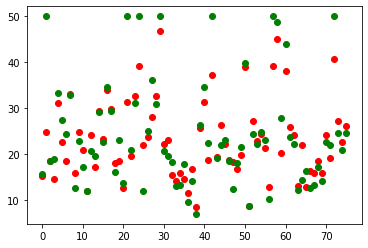

In [30]:
y_train_pred = model(X_train).numpy()
print("Error: ", mean_squared_error(y_train, y_train_pred).mean())

y_pred = model(X_test).numpy() # We take the RELu one
x = np.arange(0, len(X_test))
plt.scatter(x, y_pred, color='red') # Prediction
plt.scatter(x, y_test, color='green')

plt.show()

In [32]:
### Why are results so different ?

## With PyTorch

In [35]:
import torch
from torch.utils.data import DataLoader

def gen_dataset(x, y, batch_size=32):
    train_data = []
    for i in range(len(x)):
        train_data.append([x[i], y[i]])
    return DataLoader(train_data, batch_size = batch_size, shuffle = True)

In [38]:
# Simplified version
model = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)
num_epochs = 100
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Default LR for Keras
train_dl = gen_dataset(X_train, y_train)
for i in range(num_epochs):
    for (inputs, targets) in train_dl:
        y_pred = model(inputs)
        loss = loss_fn(y_pred, targets.reshape(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Error:  5.459994


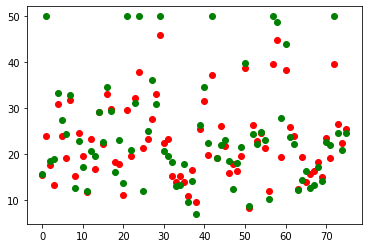

In [41]:
y_train_pred = model(torch.tensor(X_train)).detach().numpy()
print("Error: ", mean_squared_error(y_train, y_train_pred).mean())

y_pred = model(torch.tensor(X_test)).detach().numpy() # We take the RELu one
x = np.arange(0, len(X_test))
plt.scatter(x, y_pred, color='red') # Prediction
plt.scatter(x, y_test, color='green')

plt.show()